In [403]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from Scripts.dirty_accuracy import injection
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

## Helper functions

Naive Bayes Classification implementation

In [404]:
def NBClassification(X_train, y_train, X_test, y_test):
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    training_score = nb.score(X_train, y_train)
    test_score = nb.score(X_test, y_test)
    return [training_score, test_score]

Decision Tree Classification implementation

In [405]:
def DTClassification(X_train, y_train, X_test, y_test):
    dtc = DecisionTreeClassifier()
    dtc.fit(X_train, y_train)
    training_score = dtc.score(X_train, y_train)
    test_score = dtc.score(X_test, y_test)
    return [training_score, test_score]

Data Classification implementation that turns all categorical columns into numerical values

In [406]:
def DCmap(df):
    dataset = df.copy()
    for col in dataset:
        if dataset[col].dtype == object:
            to_replace = dataset[col].unique()
            value = []
            for i in range (len(to_replace)):
                value.append(i)
            dataset[col] = dataset[col].replace(to_replace=to_replace, value=value)
    return dataset

Print scores

In [407]:
def printScores(scores):
    for score in scores:
        print("Dataset dirty at: ", score['dirty'], "%")
        print(score['scores'][0],':', score['scores'][1])

Z-Score detection and correction

In [408]:
def ZScore(data, threshold):
    mean = np.mean(data)
    sd = np.std(data)
    cleaned = []
    for i in data:
        z = (i - mean) / sd
        if abs(z) > threshold:
            cleaned.append(mean)
        else:
            cleaned.append(i)
    return cleaned

DBSCAN detection and correction

In [409]:
def DBSCANDetectionColumn(data, col):
    km = KMeans(n_clusters=2)
    model = km.fit(data)
    return data[col]

In [410]:
def DBSCANDetection(data):
    columns = ["Sex","Housing","Saving_accounts","Checking_account","Purpose"]
    for col in data.columns:
        if col not in columns:
            print(col)
            columns.append(col)
            data[col] = DBSCANDetectionColumn(data[columns], col)
    return data

## Pipeline implementation

Read the dataset from CSV file
Drop the ID column

In [411]:
german = pd.read_csv("datasets/german.csv", sep=',')

Perform the injections of outliers
and append the original clean dataset to the list

In [412]:
german_list = injection(df_pandas=german, seed=10, name='german', name_class='Risk')
german_list.append(german)
for i in range(len(german_list)):
    german_list[i] = DCmap(german_list[i])

saved german-accuracy50%
saved german-accuracy60%
saved german-accuracy70%
saved german-accuracy80%
saved german-accuracy90%


Reverse the list on order to have
0 - Original Dataset
1 - 10% Dirty dataset
2 - 20% Dirty dataset
3 - 30% Dirty dataset
4 - 40% Dirty dataset
5 - 50% Dirty dataset

In [413]:
german_list.reverse()

### Functions to be repeated for each dataframe

In [414]:
def computeScoresDT(dataframe_array):
    y = german['Risk']
    scores = []
    i = 0
    for df in dataframe_array:
        X = df.drop('Risk', axis=1, errors='ignore')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        sc = DTClassification(X_train, y_train, X_test, y_test)
        scores.append({'dirty': i, 'scores': sc})
        i = i + 10
    return scores

In [415]:
def computeScoresNB(dataframe_array):
    y = german['Risk']
    scores = []
    i = 0
    for df in dataframe_array:
        X = df.drop('Risk', axis=1, errors='ignore')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        sc = NBClassification(X_train, y_train, X_test, y_test)
        scores.append({'dirty': i, 'scores': sc})
        i = i + 10
    return scores

In [416]:
def cleanDatasetsZScore(datasets):
    cleaned_list = []
    i = 6
    for df in datasets:
        cleaned = df.copy()
        for col in cleaned.columns:
            if col == 'Risk':
                continue
            cleaned[col] = ZScore(cleaned[col].values, i/10)
        cleaned_list.append(cleaned)
        i = i-1
    return cleaned_list

In [417]:
def cleanDatasetDBSCAN(datasets):
    cleaned_list = []
    for df in datasets:
        cleaned = df.copy()
        cleaned = cleaned.drop('Risk', axis=1)
        print('pre:\n')
        print(df.isnull().sum())
        cleaned = DBSCANDetection(cleaned)
        cleaned_list.append(cleaned)
    return cleaned_list

Compute scores

In [418]:
DTscores = computeScoresDT(german_list)
printScores(DTscores)

Dataset dirty at:  0 %
1.0 : 0.65
Dataset dirty at:  10 %
1.0 : 0.5866666666666667
Dataset dirty at:  20 %
1.0 : 0.58
Dataset dirty at:  30 %
1.0 : 0.57
Dataset dirty at:  40 %
1.0 : 0.57
Dataset dirty at:  50 %
1.0 : 0.61


In [419]:
NBscore = computeScoresNB(german_list)
printScores(NBscore)

Dataset dirty at:  0 %
0.69 : 0.7266666666666667
Dataset dirty at:  10 %
0.6757142857142857 : 0.6666666666666666
Dataset dirty at:  20 %
0.69 : 0.6866666666666666
Dataset dirty at:  30 %
0.6928571428571428 : 0.7066666666666667
Dataset dirty at:  40 %
0.6914285714285714 : 0.7
Dataset dirty at:  50 %
0.6942857142857143 : 0.7133333333333334


Find column by column outliers using ZScore and DBSCAN and replace them with mean value

In [420]:
cleaned_zs_lists = cleanDatasetsZScore(german_list)
cleaned_dbs_list = cleanDatasetDBSCAN(german_list)

pre:

Age                 0
Sex                 0
Job                 0
Housing             0
Saving_accounts     0
Checking_account    0
Credit_amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64
Age


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Job
Credit_amount
Duration


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


pre:

Age                 0
Sex                 0
Job                 0
Housing             0
Saving_accounts     0
Checking_account    0
Credit_amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64
Age
Job
Credit_amount
Duration


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

pre:

Age                 0
Sex                 0
Job                 0
Housing             0
Saving_accounts     0
Checking_account    0
Credit_amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64
Age
Job
Credit_amount
Duration


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

pre:

Age                 0
Sex                 0
Job                 0
Housing             0
Saving_accounts     0
Checking_account    0
Credit_amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64
Age
Job
Credit_amount


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Duration
pre:

Age                 0
Sex                 0
Job                 0
Housing             0
Saving_accounts     0
Checking_account    0
Credit_amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64
Age
Job


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Credit_amount
Duration
pre:

Age                 0
Sex                 0
Job                 0
Housing             0
Saving_accounts     0
Checking_account    0
Credit_amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64
Age
Job


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

Credit_amount
Duration


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Perform again the classification after outliers detection and print results

In [421]:
cleaned_DTscores_zs = computeScoresDT(cleaned_zs_lists)
cleaned_NBscores_zs = computeScoresNB(cleaned_zs_lists)
cleaned_DTscores_dbs = computeScoresDT(cleaned_dbs_list)
cleaned_NBscores_dbs = computeScoresNB(cleaned_dbs_list)

In [422]:
printScores(cleaned_DTscores_zs)

Dataset dirty at:  0 %
0.9128571428571428 : 0.5766666666666667
Dataset dirty at:  10 %
1.0 : 0.63
Dataset dirty at:  20 %
0.9942857142857143 : 0.66
Dataset dirty at:  30 %
0.9842857142857143 : 0.6033333333333334
Dataset dirty at:  40 %
0.9585714285714285 : 0.6433333333333333
Dataset dirty at:  50 %
0.9028571428571428 : 0.6066666666666667


In [423]:
printScores(cleaned_NBscores_zs)

Dataset dirty at:  0 %
0.6771428571428572 : 0.7
Dataset dirty at:  10 %
0.6957142857142857 : 0.7233333333333334
Dataset dirty at:  20 %
0.7028571428571428 : 0.72
Dataset dirty at:  30 %
0.6971428571428572 : 0.68
Dataset dirty at:  40 %
0.69 : 0.69
Dataset dirty at:  50 %
0.6957142857142857 : 0.73


In [424]:
printScores(cleaned_DTscores_dbs)

Dataset dirty at:  0 %
1.0 : 0.6733333333333333
Dataset dirty at:  10 %
1.0 : 0.59
Dataset dirty at:  20 %
1.0 : 0.5633333333333334
Dataset dirty at:  30 %
1.0 : 0.6
Dataset dirty at:  40 %
1.0 : 0.58
Dataset dirty at:  50 %
1.0 : 0.6


In [425]:
printScores(cleaned_NBscores_dbs)

Dataset dirty at:  0 %
0.69 : 0.7266666666666667
Dataset dirty at:  10 %
0.6757142857142857 : 0.6666666666666666
Dataset dirty at:  20 %
0.69 : 0.6866666666666666
Dataset dirty at:  30 %
0.6928571428571428 : 0.7066666666666667
Dataset dirty at:  40 %
0.6914285714285714 : 0.7
Dataset dirty at:  50 %
0.6942857142857143 : 0.7133333333333334


### Plot data preparation

Transform the score object array into an array of test scores

In [426]:
def toArray(score):
    t = []
    for s in score:
        t.append(s['scores'][1])
    return t

Preparation of plot DataFrame

In [427]:
plotData = {
    'dirty': [0, 10, 20, 30, 40, 50],
    'DTc_pre': toArray(DTscores),
    'NB_pre': toArray(NBscore),
    'DTc_zs_post': toArray(cleaned_DTscores_zs),
    'NB_zs_post': toArray(cleaned_NBscores_zs),
    'DTc_dbs_post': toArray(cleaned_DTscores_dbs),
    'NB_dbs_post': toArray(cleaned_NBscores_dbs)
}
plotDF = pd.DataFrame(plotData)

#### Comparison between pre and post detection scores for each combination of algorithms

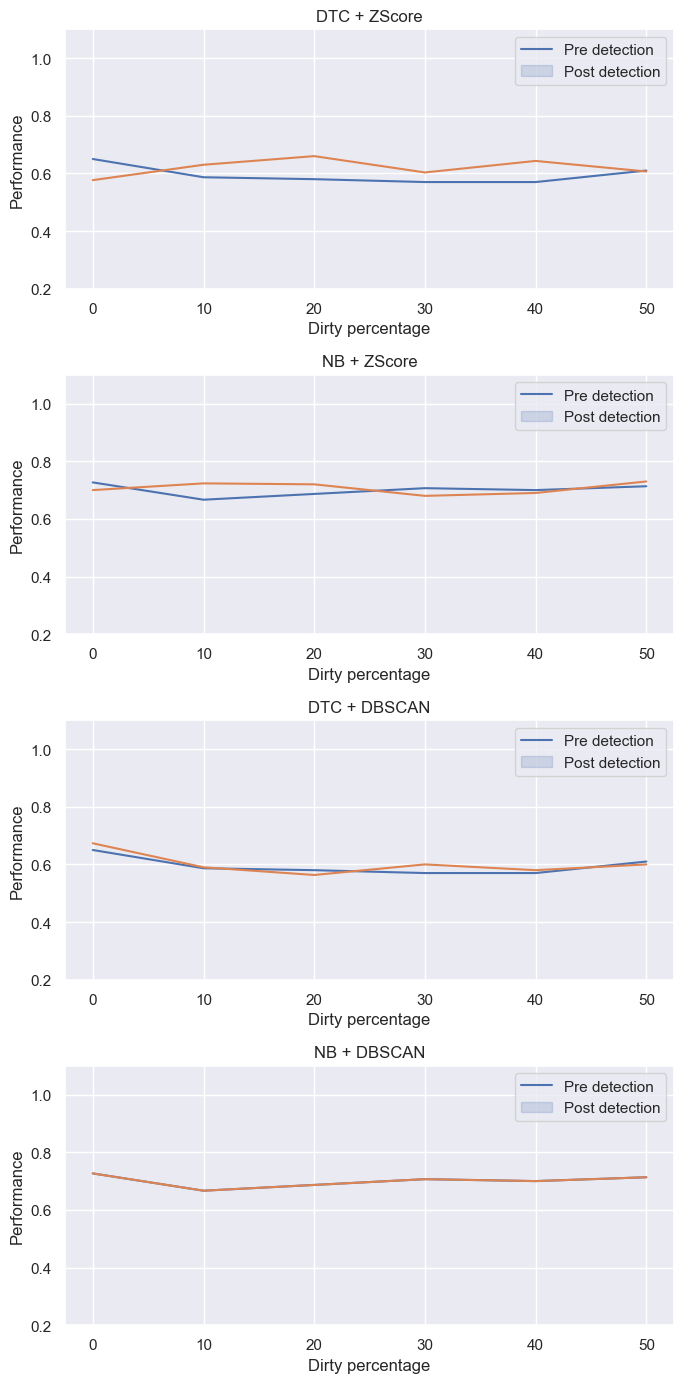

In [428]:
sns.set()
fig, axes = plt.subplots(4, 1, sharex=False, figsize=(7,14))

sns.lineplot(ax=axes[0], x='dirty', y='DTc_pre', data=plotDF)
sns.lineplot(ax=axes[0], x='dirty', y='DTc_zs_post', data=plotDF)
axes[0].legend(['Pre detection', 'Post detection'])
axes[0].set(xlabel='Dirty percentage', ylabel='Performance')
axes[0].set_ylim(0.2,1.1)
axes[0].set_title('DTC + ZScore')

sns.lineplot(ax=axes[1], x='dirty', y='NB_pre', data=plotDF)
sns.lineplot(ax=axes[1], x='dirty', y='NB_zs_post', data=plotDF)
axes[1].legend(['Pre detection', 'Post detection'])
axes[1].set(xlabel='Dirty percentage', ylabel='Performance')
axes[1].set_ylim(0.2,1.1)
axes[1].set_title('NB + ZScore')

sns.lineplot(ax=axes[2], x='dirty', y='DTc_pre', data=plotDF)
sns.lineplot(ax=axes[2], x='dirty', y='DTc_dbs_post', data=plotDF)
axes[2].legend(['Pre detection', 'Post detection'])
axes[2].set(xlabel='Dirty percentage', ylabel='Performance')
axes[2].set_ylim(0.2,1.1)
axes[2].set_title('DTC + DBSCAN')

sns.lineplot(ax=axes[3], x='dirty', y='NB_pre', data=plotDF)
sns.lineplot(ax=axes[3], x='dirty', y='NB_dbs_post', data=plotDF)
axes[3].legend(['Pre detection', 'Post detection'])
axes[3].set(xlabel='Dirty percentage', ylabel='Performance')
axes[3].set_ylim(0.2,1.1)
axes[3].set_title('NB + DBSCAN')
fig.tight_layout()

#### Comparison between the two classification algorithms pre-detection and post-detection (for each outlier detection algorithm)

Text(0.5, 1.0, 'Post detection DBSCAN performances')

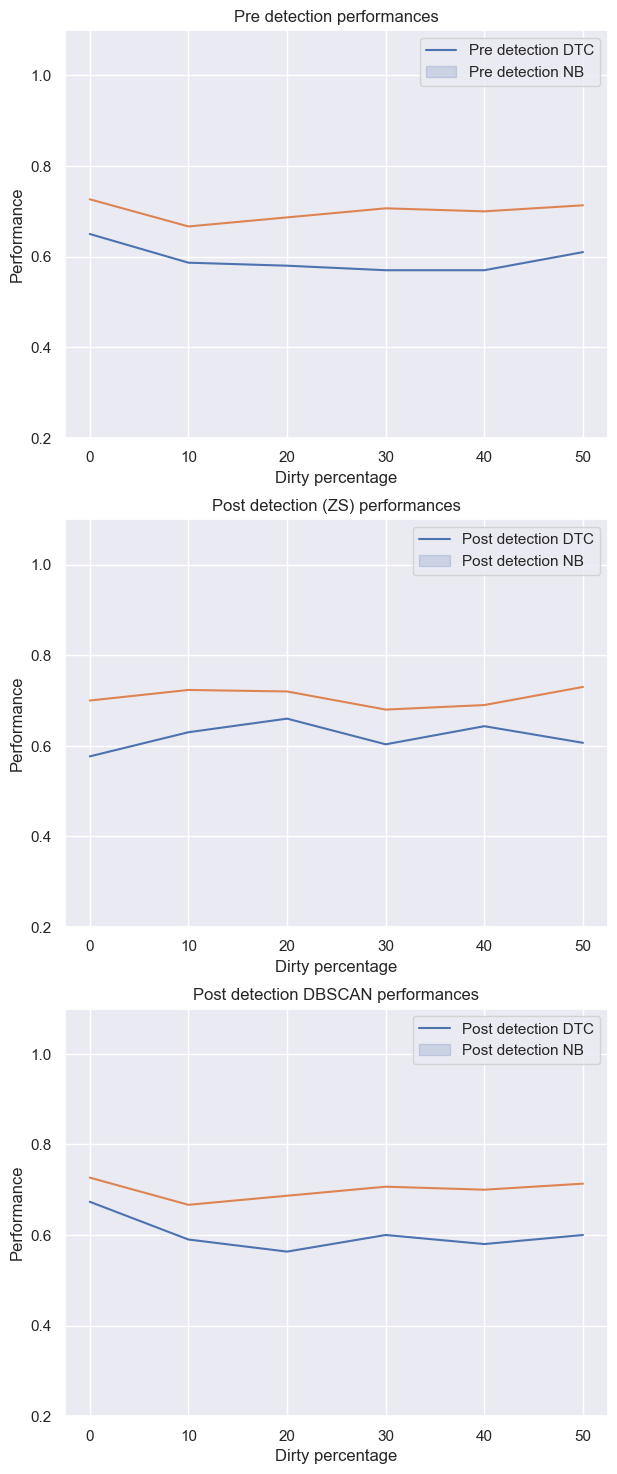

In [429]:
sns.set()
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(7,18))

sns.lineplot(ax=axes[0], x='dirty', y='DTc_pre', data=plotDF)
sns.lineplot(ax=axes[0], x='dirty', y='NB_pre', data=plotDF)
axes[0].legend(['Pre detection DTC', 'Pre detection NB'])
axes[0].set(xlabel='Dirty percentage', ylabel='Performance')
axes[0].set_ylim(0.2,1.1)
axes[0].set_title('Pre detection performances')

sns.lineplot(ax=axes[1], x='dirty', y='DTc_zs_post', data=plotDF)
sns.lineplot(ax=axes[1], x='dirty', y='NB_zs_post', data=plotDF)
axes[1].legend(['Post detection DTC', 'Post detection NB'])
axes[1].set(xlabel='Dirty percentage', ylabel='Performance')
axes[1].set_ylim(0.2,1.1)
axes[1].set_title('Post detection (ZS) performances')

sns.lineplot(ax=axes[2], x='dirty', y='DTc_dbs_post', data=plotDF)
sns.lineplot(ax=axes[2], x='dirty', y='NB_dbs_post', data=plotDF)
axes[2].legend(['Post detection DTC', 'Post detection NB'])
axes[2].set(xlabel='Dirty percentage', ylabel='Performance')
axes[2].set_ylim(0.2,1.1)
axes[2].set_title('Post detection DBSCAN performances')

#### Comparison between detection algorithms for each post-detection one

Text(0.5, 1.0, 'NB Post-detection performances')

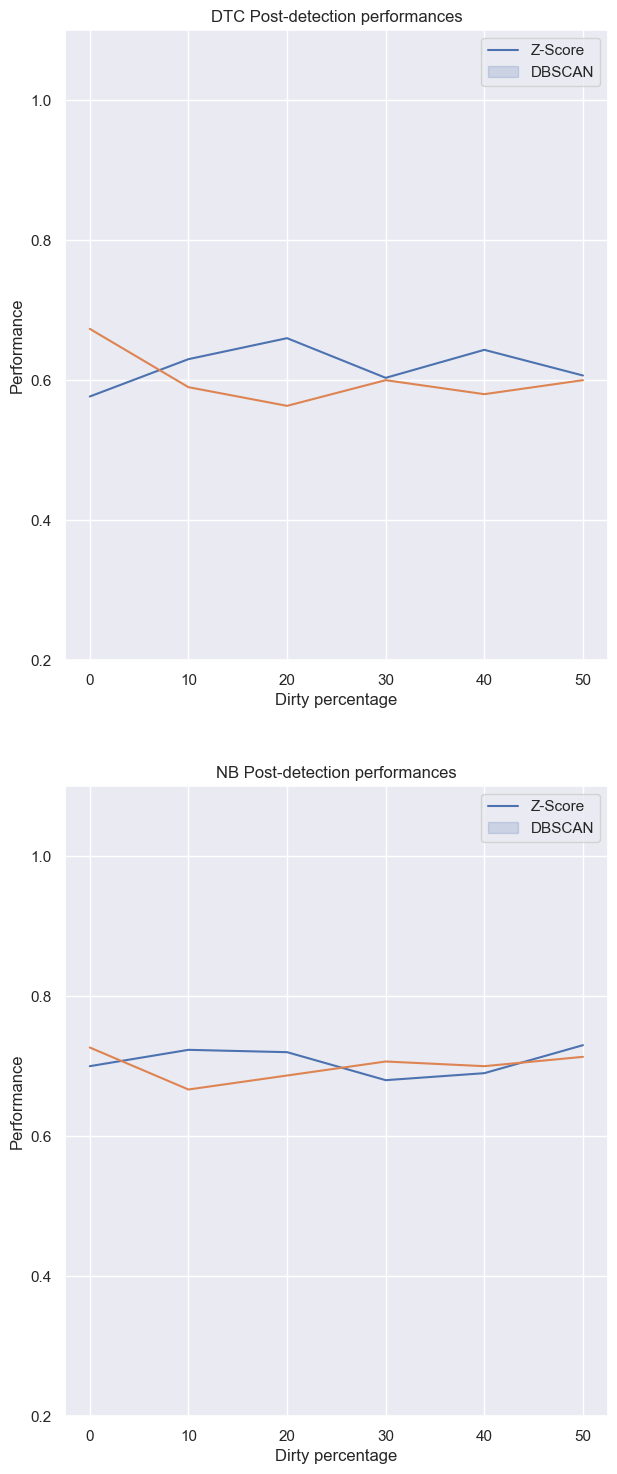

In [430]:
sns.set()
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(7,18))

sns.lineplot(ax=axes[0], x='dirty', y='DTc_zs_post', data=plotDF)
sns.lineplot(ax=axes[0], x='dirty', y='DTc_dbs_post', data=plotDF)
axes[0].legend(['Z-Score', 'DBSCAN'])
axes[0].set(xlabel='Dirty percentage', ylabel='Performance')
axes[0].set_ylim(0.2,1.1)
axes[0].set_title('DTC Post-detection performances')

sns.lineplot(ax=axes[1], x='dirty', y='NB_zs_post', data=plotDF)
sns.lineplot(ax=axes[1], x='dirty', y='NB_dbs_post', data=plotDF)
axes[1].legend(['Z-Score', 'DBSCAN'])
axes[1].set(xlabel='Dirty percentage', ylabel='Performance')
axes[1].set_ylim(0.2,1.1)
axes[1].set_title('NB Post-detection performances')